# **Projeto: Quais fatores mais influenciam no desempenho de um aluno no ENEM e como podemos ajudá-lo a melhorar sua performance?**

**Integrantes:** Hellen Cristine Silva Rosa (RA00319076), João Victor Porto (RA00311353), Laura Gabriel Murayama (RA00319321), Maria Eduarda Bonel Iribarnegaray (RA00318891), Vinícius Ferreira de Mendonça (RA00319760), Vitória de Fátima Teixeira (RA00320578)

### **Importando bibliotecas e definindo funções importantes**

In [1]:
SEED = 3

# loading environment variables
from dotenv import load_dotenv
load_dotenv()

# importing sklearn accelerator
from sklearnex import patch_sklearn, unpatch_sklearn

# importing libraries
import os
import re
import psycopg2
import pandas as pd
import skops.io as sio
import matplotlib.pyplot as plt

# importing sklearn functions
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

In [2]:
# establishing connection with DB
class db_connection():
    '''
    Instantiates a connection with the database.
    '''
    def __init__(self):
        self.DB_URI = os.environ.get('DB_URI')
         
    def __enter__(self):
        self.connection = psycopg2.connect(self.DB_URI)
        return self.connection
    
    def __exit__(self, *args):
        self.connection.close()

### **REQ#03-11: Treinamento de modelos**

Todos os modelos serão testados com 30% dos dados. A avaliação será feita a partir das métricas acurácia, precision, recall, F1 e matriz de confusão. Eles serão persistidos.

In [3]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.complete_private_data
    ORDER BY "NU_INSCRICAO" ASC;
    '''

    cursor.execute(query)
    complete_private_data_fetched = cursor.fetchall()
    complete_private_data_columns = tuple(desc[0] for desc in cursor.description)


complete_private_data = pd.DataFrame(complete_private_data_fetched, columns=complete_private_data_columns)
complete_private_data

,NU_INSCRICAO,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_SEXO,MICRODADOS_TP_COR_RACA,MICRODADOS_REGIAO_ESCOLA,MICRODADOS_NU_NOTA_MEDIA,MICRODADOS_NU_NOTA_CONCEITO,MICRODADOS_RENDA_PER_CAPITA,HABESTUDO_Q005,HABESTUDO_Q006,...,HABESTUDO_Q028I,HABESTUDO_Q028J,HABESTUDO_Q028K,HABESTUDO_Q028L,HABESTUDO_Q028M,HABESTUDO_Q028N,HABESTUDO_Q028O,HABESTUDO_Q028P,HABESTUDO_Q028Q,HABESTUDO_Q028R
0,210054480429,3,M,1,Norte,485.64,1,707.0,A,A,...,B,B,B,B,B,B,B,B,B,B
1,210054481135,3,F,1,Norte,652.08,3,1818.0,C,D,...,A,A,B,B,A,B,B,B,B,B
2,210054482583,2,F,1,Norte,627.22,3,1111.0,C,D,...,B,B,B,B,B,B,B,B,B,B
3,210054484900,1,M,3,Norte,472.54,1,424.2,B,B,...,B,B,B,A,B,A,B,B,A,B
4,210054490288,2,M,3,Norte,674.70,3,1818.0,B,B,...,B,B,B,B,B,B,B,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,210058018555,2,F,3,Sudeste,440.58,0,3434.0,B,C,...,B,B,B,B,B,B,B,B,B,B
2344,210058019736,4,F,3,Sudeste,473.86,1,151.5,B,B,...,B,B,B,B,B,B,B,B,B,B
2345,210058020771,2,F,1,Sul,464.94,1,424.2,B,B,...,B,B,B,B,B,B,B,B,B,B
2346,210058021639,2,F,1,Nordeste,623.64,3,1363.5,C,C,...,B,B,B,B,B,B,B,B,B,B


#### **Pré-processamento**

**ordinal:** 'HABESTUDO_Q005', 'HABESTUDO_Q006', 'HABESTUDO_Q007', 'HABESTUDO_Q008', 'HABESTUDO_Q021', 'HABESTUDO_Q022', 'HABESTUDO_Q009', 'HABESTUDO_Q010', 'HABESTUDO_Q011', 'HABESTUDO_Q012', 'HABESTUDO_Q013', 'HABESTUDO_Q014', 'HABESTUDO_Q015', 'HABESTUDO_Q016', 'HABESTUDO_Q017', 'HABESTUDO_Q018', 'HABESTUDO_Q019', 'HABESTUDO_Q020', 'HABESTUDO_Q023', 'HABESTUDO_Q024', 'HABESTUDO_Q027', 'HABESTUDO_Q028A', 'HABESTUDO_Q028B', 'HABESTUDO_Q028C', 'HABESTUDO_Q028D', 'HABESTUDO_Q028E', 'HABESTUDO_Q028F', 'HABESTUDO_Q028G', 'HABESTUDO_Q028H', 'HABESTUDO_Q028I', 'HABESTUDO_Q028J', 'HABESTUDO_Q028K', 'HABESTUDO_Q028L', 'HABESTUDO_Q028M', 'HABESTUDO_Q028N', 'HABESTUDO_Q028O', 'HABESTUDO_Q028P', 'HABESTUDO_Q028Q', 'HABESTUDO_Q028R'

**nominal:** 'MICRODADOS_TP_SEXO', 'MICRODADOS_REGIAO_ESCOLA'

**numerical:** 'NU_INSCRICAO', 'MICRODADOS_TP_FAIXA_ETARIA', 'MICRODADOS_TP_COR_RACA', 'MICRODADOS_TP_ST_CONCLUSAO', 'MICRODADOS_TP_ANO_CONCLUIU', 'MICRODADOS_TP_ESCOLA', 'MICRODADOS_IN_TREINEIRO', 'MICRODADOS_TP_PRESENCA_CN', 'MICRODADOS_TP_PRESENCA_CH', 'MICRODADOS_TP_PRESENCA_LC', 'MICRODADOS_TP_PRESENCA_MT', 'MICRODADOS_NU_NOTA_CN', 'MICRODADOS_NU_NOTA_CH', 'MICRODADOS_NU_NOTA_LC', 'MICRODADOS_NU_NOTA_MT', 'MICRODADOS_NU_NOTA_REDACAO', 'MICRODADOS_TP_STATUS_REDACAO', 'MICRODADOS_NU_NOTA_COMP1', 'MICRODADOS_NU_NOTA_COMP2', 'MICRODADOS_NU_NOTA_COMP3', 'MICRODADOS_NU_NOTA_COMP4', 'MICRODADOS_NU_NOTA_COMP5', 'MICRODADOS_NU_NOTA_MEDIA', 'MICRODADOS_NU_NOTA_CONCEITO', 'MICRODADOS_NU_ACERTOS_CN', 'MICRODADOS_NU_ACERTOS_CH', 'MICRODADOS_NU_ACERTOS_LC', 'MICRODADOS_NU_ACERTOS_MT', 'MICRODADOS_NU_ACERTOS_TOTAL', 'MICRODADOS_NU_ACERTOS_MEDIO', 'MICRODADOS_TP_LINGUA', 'MICRODADOS_RENDA_PER_CAPITA'

In [4]:
ordinal_features = ['HABESTUDO_Q005', 'HABESTUDO_Q006', 'HABESTUDO_Q007', 'HABESTUDO_Q008', 'HABESTUDO_Q021', 'HABESTUDO_Q022', 'HABESTUDO_Q009', 'HABESTUDO_Q010', 'HABESTUDO_Q011', 'HABESTUDO_Q012', 'HABESTUDO_Q013', 'HABESTUDO_Q014', 'HABESTUDO_Q015', 'HABESTUDO_Q016', 'HABESTUDO_Q017', 'HABESTUDO_Q018', 'HABESTUDO_Q019', 'HABESTUDO_Q020', 'HABESTUDO_Q023', 'HABESTUDO_Q024', 'HABESTUDO_Q027', 'HABESTUDO_Q028A', 'HABESTUDO_Q028B', 'HABESTUDO_Q028C', 'HABESTUDO_Q028D', 'HABESTUDO_Q028E', 'HABESTUDO_Q028F', 'HABESTUDO_Q028G', 'HABESTUDO_Q028H', 'HABESTUDO_Q028I', 'HABESTUDO_Q028J', 'HABESTUDO_Q028K', 'HABESTUDO_Q028L', 'HABESTUDO_Q028M', 'HABESTUDO_Q028N', 'HABESTUDO_Q028O', 'HABESTUDO_Q028P', 'HABESTUDO_Q028Q', 'HABESTUDO_Q028R']
nominal_features = list(set(complete_private_data.select_dtypes(include='object').columns.values) - set(ordinal_features))
numerical_features = list(set(complete_private_data.select_dtypes(exclude='object').columns.values) - set(ordinal_features))

In [5]:
ordinal_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q005
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q006
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q007
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q008
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q021
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q022
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q009
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q010
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q011
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q012
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q013
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q014
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q015
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q016
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q017
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q018
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q019
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q020
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q023
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q024
        ('B', 'A'),   # HABESTUDO_Q027
        ('B', 'A'),   # HABESTUDO_Q028A
        ('B', 'A'),   # HABESTUDO_Q028B
        ('B', 'A'),   # HABESTUDO_Q028C
        ('B', 'A'),   # HABESTUDO_Q028D
        ('B', 'A'),   # HABESTUDO_Q028E
        ('B', 'A'),   # HABESTUDO_Q028F
        ('B', 'A'),   # HABESTUDO_Q028G
        ('B', 'A'),   # HABESTUDO_Q028H
        ('B', 'A'),   # HABESTUDO_Q028I
        ('B', 'A'),   # HABESTUDO_Q028J
        ('B', 'A'),   # HABESTUDO_Q028K
        ('B', 'A'),   # HABESTUDO_Q028L
        ('B', 'A'),   # HABESTUDO_Q028M
        ('B', 'A'),   # HABESTUDO_Q028N
        ('B', 'A'),   # HABESTUDO_Q028O
        ('B', 'A'),   # HABESTUDO_Q028P
        ('B', 'A'),   # HABESTUDO_Q028Q
        ('B', 'A'),   # HABESTUDO_Q028R
    ])),
])

nominal_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder()),
])

preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_features),
    ('nominal', nominal_transformer, nominal_features),
], remainder='passthrough')

In [6]:
X = complete_private_data.drop(columns=['NU_INSCRICAO', 'MICRODADOS_NU_NOTA_MEDIA', 'MICRODADOS_NU_NOTA_CONCEITO'])

X_transformed = preprocessor.fit_transform(X)
y_numerical_transformed = complete_private_data['MICRODADOS_NU_NOTA_MEDIA']
y_categorical_transformed = complete_private_data['MICRODADOS_NU_NOTA_CONCEITO']

In [7]:
preprocessor_feature_names = preprocessor.get_feature_names_out()
preprocessor_feature_names = [re.sub(r'.+__', '', item) for item in preprocessor_feature_names]

In [8]:
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor_feature_names)
X_transformed = X_transformed.drop(columns='MICRODADOS_TP_SEXO_M').reset_index(drop=True)
X_transformed

,HABESTUDO_Q005,HABESTUDO_Q006,HABESTUDO_Q007,HABESTUDO_Q008,HABESTUDO_Q021,HABESTUDO_Q022,HABESTUDO_Q009,HABESTUDO_Q010,HABESTUDO_Q011,HABESTUDO_Q012,...,HABESTUDO_Q028R,MICRODADOS_REGIAO_ESCOLA_Centro-Oeste,MICRODADOS_REGIAO_ESCOLA_Nordeste,MICRODADOS_REGIAO_ESCOLA_Norte,MICRODADOS_REGIAO_ESCOLA_Sudeste,MICRODADOS_REGIAO_ESCOLA_Sul,MICRODADOS_TP_SEXO_F,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_COR_RACA,MICRODADOS_RENDA_PER_CAPITA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,707.0
1,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1818.0
2,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,1111.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,424.2
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1818.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,3.0,3434.0
2344,1.0,1.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,3.0,151.5
2345,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,424.2
2346,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1363.5


In [9]:
X_numerical_train, X_numerical_test, y_numerical_train, y_numerical_test = train_test_split(X_transformed, y_numerical_transformed, test_size=0.3, random_state=SEED)

X_categorical_train, X_categorical_test, y_categorical_train, y_categorical_test = train_test_split(X_transformed, y_categorical_transformed, test_size=0.3, random_state=SEED)

In [10]:
# accelerating sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### **kNN**

**Classificador**

In [11]:
knn_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=3)),
])

In [12]:
knn_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

In [13]:
knn_classifier_preds = knn_classifier_pipe.predict(X_categorical_train)
knn_classifier_preds

array([0, 3, 3, ..., 3, 0, 2])

Acurácia

In [14]:
knn_classifier_accuracy_scores = cross_val_score(knn_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='accuracy')
knn_classifier_accuracy_scores.mean()

0.4646400217756204

Precisão

In [15]:
knn_classifier_precision_scores = cross_val_score(knn_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='precision_weighted')
knn_classifier_precision_scores.mean()

0.4841712955713528

Recall

In [16]:
knn_classifier_recall_scores = cross_val_score(knn_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='recall_weighted')
knn_classifier_recall_scores.mean()

0.4646400217756204

F1-score

In [17]:
knn_classifier_f1_scores = cross_val_score(knn_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='f1_weighted')
knn_classifier_f1_scores.mean()

0.4713363444749641

Relatório de Classificação

In [18]:
print(classification_report(y_categorical_train, knn_classifier_preds))

              precision    recall  f1-score   support

           0       0.39      0.61      0.48        75
           1       0.42      0.62      0.51       162
           2       0.69      0.47      0.56       401
           3       0.82      0.82      0.82      1005

    accuracy                           0.71      1643
   macro avg       0.58      0.63      0.59      1643
weighted avg       0.73      0.71      0.71      1643



Matriz de confusão

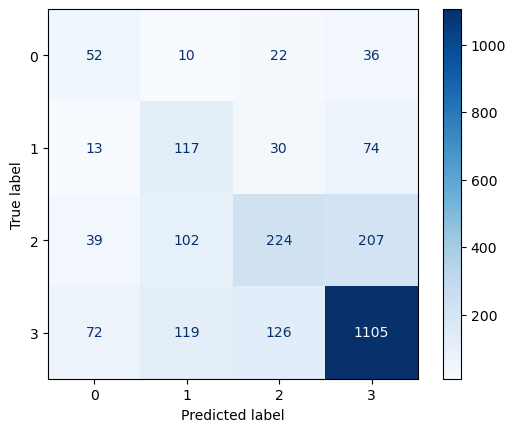

In [19]:
ConfusionMatrixDisplay.from_estimator(knn_classifier_pipe, X_transformed, y_categorical_transformed, cmap='Blues')
plt.show()

In [20]:
sio.dump(knn_classifier_pipe, '../modelos/knn_classifier.skops')

**Regressor**


In [21]:
knn_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', KNeighborsRegressor(n_neighbors=3)),
])

In [22]:
knn_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', KNeighborsRegressor(n_neighbors=3))])

Erro médio absoluto

In [23]:
knn_regressor_mae_scores = -1 * cross_val_score(knn_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_error')
knn_regressor_mae_scores.mean()

66.61352745694023

Raiz Quadrada do Erro Médio

In [24]:
knn_regressor_rmse_scores = -1 * cross_val_score(knn_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_root_mean_squared_error')
knn_regressor_rmse_scores.mean()

84.57734895351953

Coeficiente de determinação

In [25]:
knn_regressor_r2_scores = -1 * cross_val_score(knn_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='r2')
knn_regressor_r2_scores.mean()

0.11799272841522974

Erro percentual absoluto médio

In [26]:
knn_regressor_mape_scores = -1 * cross_val_score(knn_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_percentage_error')
knn_regressor_mape_scores.mean()

0.11722154368978699

In [27]:
sio.dump(knn_regressor_pipe, '../modelos/knn_regressor.skops')

#### **Regressão Linear**

In [28]:
linear_regression_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression()),
])

In [29]:
linear_regression_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [30]:
linear_regression_mae_scores = -1 * cross_val_score(linear_regression_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_error')
linear_regression_mae_scores.mean()

100.59006351138564

In [31]:
linear_regression_rmse_scores = -1 * cross_val_score(linear_regression_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_root_mean_squared_error')
linear_regression_rmse_scores.mean()

1030.6256221660742

In [32]:
linear_regression_r2_scores = cross_val_score(linear_regression_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='r2')
linear_regression_r2_scores.mean()

-898.4172053461664

In [33]:
linear_regression_mape_scores = -1 * cross_val_score(linear_regression_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_percentage_error')
linear_regression_mape_scores.mean()

0.1782455391692643

In [34]:
sio.dump(linear_regression_pipe, '../modelos/linear_regression.skops')

#### **Regressão Logística**

In [35]:
unpatch_sklearn()

In [36]:
logistic_regression_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=SEED)),
])

In [37]:
logistic_regression_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=3))])

In [38]:
logistic_regression_preds = logistic_regression_pipe.predict(X_categorical_train)
logistic_regression_preds

array([1, 3, 3, ..., 3, 3, 3])

In [39]:
logistic_regression_accuracy_scores = cross_val_score(logistic_regression_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='accuracy')
logistic_regression_accuracy_scores.mean()

0.5966873837499433

In [40]:
logistic_regression_precision_scores = cross_val_score(logistic_regression_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='precision_weighted')
logistic_regression_precision_scores.mean()

0.5075216989504556

In [41]:
logistic_regression_recall_scores = cross_val_score(logistic_regression_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='recall_weighted')
logistic_regression_recall_scores.mean()

0.5966873837499433

In [42]:
logistic_regression_f1_scores = cross_val_score(logistic_regression_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='f1_weighted')
logistic_regression_f1_scores.mean()

0.513881628839916

In [43]:
print(classification_report(y_categorical_train, logistic_regression_preds))

              precision    recall  f1-score   support

           0       0.41      0.09      0.15        75
           1       0.64      0.09      0.15       162
           2       0.41      0.22      0.29       401
           3       0.67      0.92      0.78      1005

    accuracy                           0.63      1643
   macro avg       0.53      0.33      0.34      1643
weighted avg       0.59      0.63      0.57      1643



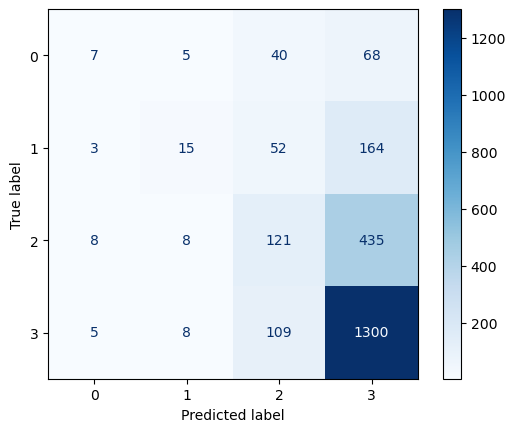

In [44]:
ConfusionMatrixDisplay.from_estimator(logistic_regression_pipe, X_transformed, y_categorical_transformed, cmap='Blues')
plt.show()

In [45]:
sio.dump(logistic_regression_pipe, '../modelos/logistic_regression.skops')

In [46]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### **Naive Bayes**

In [47]:
naive_bayes_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB()),
])

In [48]:
naive_bayes_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()), ('classifier', GaussianNB())])

In [49]:
naive_bayes_preds = naive_bayes_pipe.predict(X_categorical_train)
naive_bayes_preds

array([0, 0, 1, ..., 0, 0, 0])

In [50]:
naive_bayes_accuracy_scores = cross_val_score(naive_bayes_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='accuracy')
naive_bayes_accuracy_scores.mean()

0.24658077394184091

In [51]:
naive_bayes_precision_scores = cross_val_score(naive_bayes_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='precision_weighted')
naive_bayes_precision_scores.mean()

/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvporto/o

0.5059752517293707

In [52]:
naive_bayes_recall_scores = cross_val_score(naive_bayes_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='recall_weighted')
naive_bayes_recall_scores.mean()

0.24658077394184091

In [53]:
naive_bayes_f1_scores = cross_val_score(naive_bayes_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='f1_weighted')
naive_bayes_f1_scores.mean()

0.284695491483585

In [54]:
print(classification_report(y_categorical_train, naive_bayes_preds))

              precision    recall  f1-score   support

           0       0.05      0.99      0.10        75
           1       0.28      0.03      0.06       162
           2       1.00      0.00      0.00       401
           3       0.81      0.16      0.27      1005

    accuracy                           0.15      1643
   macro avg       0.53      0.30      0.11      1643
weighted avg       0.77      0.15      0.18      1643



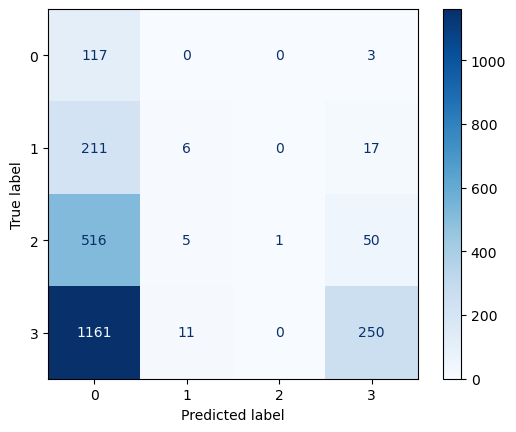

In [55]:
ConfusionMatrixDisplay.from_estimator(naive_bayes_pipe, X_transformed, y_categorical_transformed, cmap='Blues')
plt.show()

In [56]:
sio.dump(naive_bayes_pipe, '../modelos/naive_bayes.skops')

#### **SVM**

**Classificador**

In [57]:
svm_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=SEED)),
])

In [58]:
svm_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(random_state=3))])

In [59]:
svm_classifier_preds = svm_classifier_pipe.predict(X_categorical_train)
svm_classifier_preds

array([2, 3, 3, ..., 3, 3, 3])

In [60]:
svm_classifier_accuracy_scores = cross_val_score(svm_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='accuracy')
svm_classifier_accuracy_scores.mean()

0.6107317515764642

In [61]:
svm_classifier_precision_scores = cross_val_score(svm_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='precision_weighted')
svm_classifier_precision_scores.mean()

/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvporto/o

0.4613391962249909

In [62]:
svm_classifier_recall_scores = cross_val_score(svm_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='recall_weighted')
svm_classifier_recall_scores.mean()

0.6107317515764642

In [63]:
svm_classifier_f1_scores = cross_val_score(svm_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='f1_weighted')
svm_classifier_f1_scores.mean()

0.48622633113725333

In [64]:
print(classification_report(y_categorical_train, svm_classifier_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       1.00      0.01      0.02       162
           2       0.66      0.20      0.31       401
           3       0.66      0.99      0.79      1005

    accuracy                           0.66      1643
   macro avg       0.58      0.30      0.28      1643
weighted avg       0.66      0.66      0.56      1643



/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

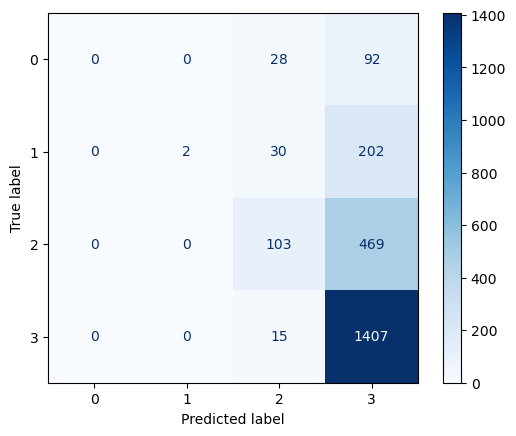

In [65]:
ConfusionMatrixDisplay.from_estimator(svm_classifier_pipe, X_transformed, y_categorical_transformed, cmap='Blues')
plt.show()

In [66]:
sio.dump(svm_classifier_pipe, '../modelos/svm_classifier.skops')

**Regressor**

In [67]:
svm_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', SVR()),
])

In [68]:
svm_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', SVR())])

In [69]:
svm_regressor_mae_scores = -1 * cross_val_score(svm_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_error')
svm_regressor_mae_scores.mean()

60.52958703479677

In [70]:
svm_regressor_rmse_scores = -1 * cross_val_score(svm_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_root_mean_squared_error')
svm_regressor_rmse_scores.mean()

75.61761798091922

In [71]:
svm_regressor_r2_scores = cross_val_score(svm_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='r2')
svm_regressor_r2_scores.mean()

0.11011105947742927

In [72]:
svm_regressor_mape_scores = -1 * cross_val_score(svm_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_percentage_error')
svm_regressor_mape_scores.mean()

0.10892669249053595

In [73]:
sio.dump(svm_regressor_pipe, '../modelos/svm_regressor.skops')

#### **Random Forest**

**Classificador**

In [74]:
randomforest_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=SEED)),
])

In [75]:
randomforest_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=3))])

In [76]:
randomforest_classifier_preds = randomforest_classifier_pipe.predict(X_categorical_train)
randomforest_classifier_preds

array([1, 3, 3, ..., 3, 0, 3])

In [77]:
randomforest_classifier_accuracy_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='accuracy')
randomforest_classifier_accuracy_scores.mean()

0.600509005126344

In [78]:
randomforest_classifier_precision_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='precision_weighted')
randomforest_classifier_precision_scores.mean()

0.4784846238725941

In [79]:
randomforest_classifier_recall_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='recall_weighted')
randomforest_classifier_recall_scores.mean()

0.600509005126344

In [80]:
randomforest_classifier_f1_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='f1_weighted')
randomforest_classifier_f1_scores.mean()

0.5076030808080978

In [81]:
print(classification_report(y_categorical_train, randomforest_classifier_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00       162
           2       1.00      1.00      1.00       401
           3       1.00      1.00      1.00      1005

    accuracy                           1.00      1643
   macro avg       1.00      1.00      1.00      1643
weighted avg       1.00      1.00      1.00      1643



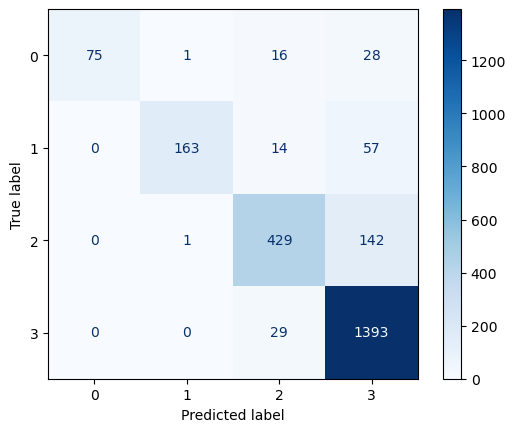

In [82]:
ConfusionMatrixDisplay.from_estimator(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cmap='Blues')
plt.show()

In [83]:
randomforest_classifier_feature_importances = pd.Series(randomforest_classifier_pipe['classifier'].feature_importances_, index=X_categorical_train.columns)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.sort_values(ascending=False)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_classifier_feature_importances

MICRODADOS_RENDA_PER_CAPITA              10.81
MICRODADOS_TP_FAIXA_ETARIA                3.45
MICRODADOS_TP_COR_RACA                    3.44
HABESTUDO_Q022                            3.15
HABESTUDO_Q024                            3.01
HABESTUDO_Q020                            2.98
HABESTUDO_Q021                            2.98
HABESTUDO_Q013                            2.97
HABESTUDO_Q019                            2.88
HABESTUDO_Q005                            2.82
HABESTUDO_Q007                            2.73
HABESTUDO_Q018                            2.71
HABESTUDO_Q012                            2.69
HABESTUDO_Q010                            2.68
HABESTUDO_Q009                            2.56
HABESTUDO_Q023                            2.54
HABESTUDO_Q017                            2.48
HABESTUDO_Q006                            2.42
HABESTUDO_Q011                            2.42
HABESTUDO_Q015                            2.40
HABESTUDO_Q008                            2.38
HABESTUDO_Q02

In [84]:
sio.dump(randomforest_classifier_pipe, '../modelos/randomforest_classifier.skops')

**Regressor**

In [85]:
randomforest_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=SEED)),
])

In [86]:
randomforest_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=3))])

In [87]:
randomforest_regressor_mae_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_error')
randomforest_regressor_mae_scores.mean()

58.22848996561267

In [88]:
randomforest_regressor_rmse_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_root_mean_squared_error')
randomforest_regressor_rmse_scores.mean()

73.0453289350921

In [89]:
randomforest_regressor_r2_scores = cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='r2')
randomforest_regressor_r2_scores.mean()

0.1689152069089613

In [90]:
randomforest_regressor_mape_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_percentage_error')
randomforest_regressor_mape_scores.mean()

0.10368056838792739

In [91]:
randomforest_regressor_feature_importances = pd.Series(randomforest_regressor_pipe['regressor'].feature_importances_, index=X_numerical_train.columns)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.sort_values(ascending=False)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_regressor_feature_importances

MICRODADOS_RENDA_PER_CAPITA              14.92
HABESTUDO_Q028G                           6.37
HABESTUDO_Q028J                           3.23
HABESTUDO_Q020                            3.18
MICRODADOS_TP_FAIXA_ETARIA                3.17
HABESTUDO_Q007                            3.10
HABESTUDO_Q018                            3.10
HABESTUDO_Q024                            2.97
HABESTUDO_Q006                            2.86
HABESTUDO_Q013                            2.82
MICRODADOS_TP_COR_RACA                    2.75
HABESTUDO_Q005                            2.72
HABESTUDO_Q011                            2.71
HABESTUDO_Q019                            2.62
HABESTUDO_Q022                            2.61
HABESTUDO_Q021                            2.33
HABESTUDO_Q014                            2.32
HABESTUDO_Q009                            2.18
HABESTUDO_Q010                            2.13
HABESTUDO_Q012                            2.02
HABESTUDO_Q028D                           1.99
HABESTUDO_Q02

In [92]:
sio.dump(randomforest_regressor_pipe, '../modelos/randomforest_regressor.skops')